In [1]:
%matplotlib inline
import sys, srwl_bl
sys.path.insert(0,r"C:\Users\nanw0\GoogleDrive\SLAC\SLAC-Diling\8. 20 Winter\Beam_propagation\WPG\WPG-develop")

%load_ext autoreload

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

#Importing necessary modules:
import os
import sys
import copy

sys.path.insert(0,os.path.join('..','..'))
#sys.path.insert('../..')

import time
import numpy as np
import pylab as plt

if sys.version_info[0] ==3:
    import pickle
else:
    import cPickle as pickle
import errno

#import SRW core functions
from wpg.srwlib import srwl, srwl_opt_setup_CRL, SRWLOptCryst, SRWLOptD, SRWLOptA, SRWLOptC, SRWLOptT

#import SRW auxiliary functions
from wpg.useful_code.srwutils import AuxTransmAddSurfHeightProfileScaled

#import some helpers functions
from wpg.useful_code.wfrutils import calculate_fwhm_x, plot_wfront, calculate_fwhm_y, print_beamline, get_mesh, plot_1d, plot_2d

from wpg.wpg_uti_wf import propagate_wavefront
from wpg.wpg_uti_oe import show_transmission

#from wpg.useful_code.wfrutils import propagate_wavefront

#Import base wavefront class
from wpg import Wavefront

#Import base beamline class and OE wrappers
from wpg.beamline import Beamline
from wpg.optical_elements import Empty, Use_PP
from wpg.optical_elements import         Drift,Aperture,    Lens,Mirror_elliptical,WF_dist,calculateOPD

#Gaussian beam generator
from wpg.generators import build_gauss_wavefront, build_gauss_wavefront_xy

plt.ion()

In [3]:
''' auxiliary function '''
def E2L(e):
    hbar = 6.582119569e-16
    omega = e/hbar
    frequency = omega /2/np.pi
    wavelength = 3e8/frequency
    return wavelength

def E2k(e):
    wavelength = E2L(e)
    k = 2*np.pi/wavelength
    return k

def mkdir(path):
    """
    Create directory with subfolders (like Linux mkdir -p)

    :param path: Path to be created
    """
    try:
        os.makedirs(path)
    except OSError as exc: # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else: raise

def plot_spatial_from_wf(wf):
    srwl.SetRepresElecField(wf._srwl_wf, 't')
    [xmin, xmax, ymin, ymax] = wf.get_limits()
    img = wf.get_intensity().sum(axis=-1)
    plt.imshow(img,cmap='jet',
        extent = [xmin*1e6, xmax*1e6, ymin*1e6, ymax*1e6])
    plt.colorbar()
    plt.xlabel(r'x ($\mu$m)',fontsize=18)
    plt.ylabel(r'y ($\mu$m)',fontsize=18)

def get_temporal(wf):
    # change the wavefront into time domain, where each slice in z represent a time
    srwl.SetRepresElecField(wf._srwl_wf, 't')
    mesh = wf.params.Mesh
    dx = (mesh.xMax - mesh.xMin) / (mesh.nx - 1)        # spatial sampling resolution
    dy = (mesh.yMax - mesh.yMin) / (mesh.ny - 1)
    int0 = wf.get_intensity().sum(axis=0).sum(axis=0)   # intensity per slice
    #int0_00 = wf.get_intensity()[int(mesh.ny/2), int(mesh.nx/2),:]  # central intensity
    dSlice = (mesh.sliceMax - mesh.sliceMin)/(mesh.nSlices-1)   # time sampling resolution
    axis_t = np.arange(mesh.nSlices) * dSlice + mesh.sliceMin  # time axis

    # get meaningful slices (>1% maximum intensity)
    int0max = max(int0)                                 # maximum intensity slice
    aw = [a[0] for a in np.argwhere(int0>int0max*0.01)] # meaningful indices
    aw = np.asarray(aw)
    #int0_mean = int0[min(aw):max(aw)]                   # meaningful intensity slices
    #axis_t = np.arange(min(aw),max(aw)) * dSlice + mesh.sliceMin # meaningful time axis
    return aw, axis_t, int0

def get_tilt(wf, ori='V'):
    srwl.SetRepresElecField(wf._srwl_wf, 't')
    [xmin, xmax, ymin, ymax] = wf.get_limits()
    mesh = wf.params.Mesh
    if ori == 'V':
        axis = np.linspace(ymin, ymax, mesh.ny)
        tilt = wf.get_intensity()[:,int(mesh.nx/2),:]
    else:
        axis = np.linspace(xmin, xmax, mesh.nx)
        tilt = wf.get_intensity()[int(mesh.ny/2),:,:]
    return axis, tilt

def plot_tilt(axis, tilt, axis_t, label=None, ori='V', if_log=0):
    tilt = tilt/tilt.max()
    tilt = tilt + 1e-30
    if ori == 'V':
        alabel = 'y'
    else:
        alabel = 'x'
    title = 'wavefront tilt at '+label
    if if_log == 1:
        tilt = np.log(tilt)
        title = title+', log'
    plt.imshow(tilt, cmap='jet',
              extent = [axis_t.max()*1e15, axis_t.min()*1e15, axis.max()*1e6, axis.min()*1e6])
    plt.colorbar()
    if if_log == 1:
        cmin = np.max(tilt)-10
        plt.clim(cmin)
    plt.axis('tight')
    plt.title(title, fontsize=18)
    plt.xlabel('time (fs)', fontsize=18)
    plt.ylabel(alabel+r' ($\mu$m)', fontsize=18)

def plot_tilt_from_wf(wf, label=None, ori='V', if_log=0):
    axis, tilt = get_tilt(wf, ori=ori)
    _, axis_t, _ = get_temporal(wf)
    plot_tilt(axis, tilt, axis_t, label=label, ori=ori, if_log=if_log)
    
def get_axis_ev(wf):
    srwl.SetRepresElecField(wf._srwl_wf, 'f')
    mesh = wf.params.Mesh
    if mesh.nSlices == 1:
        axis_ev = np.asarray([mesh.sliceMax])
    else:
        axis_ev = np.arange(mesh.nSlices) * (mesh.sliceMax - mesh.sliceMin)/(mesh.nSlices-1) + mesh.sliceMin
    srwl.SetRepresElecField(wf._srwl_wf, 't')
    return axis_ev

def get_refractive_index(axis_ev):
    cxro_data = np.genfromtxt('Be.csv',delimiter=',')
    ev = cxro_data[:,0]
    delta = cxro_data[:,1]
    beta = cxro_data[:,2]
    
    delta1 = np.interp(axis_ev, ev, delta)
    beta1 = np.interp(axis_ev, ev, beta)
    return delta1, beta1

def set_crystal_orient(cryst, e, ang_dif_pl, flip=0):
    if flip == 1:
        ang_dif_pl = ang_dif_pl+np.pi
    nvx, nvy, nvz = cryst.find_orient(
        e,ang_dif_pl)[0][2]             # outward normal vector to crystal surface
    tvx, tvy, _ = cryst.find_orient(
        e,ang_dif_pl)[0][0]      # central tangential vector
    cryst.set_orient(nvx,nvy,nvz,tvx,tvy)
    

R-space


Text(0.5, 1.0, 'incident beam')

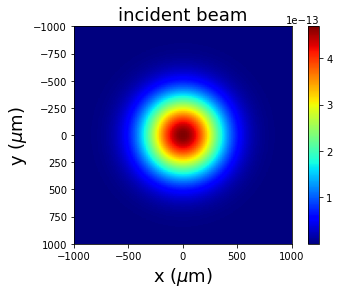

In [4]:
''' build incident Gaussian beam '''
z_source = 630    # source position as in LCLS coordinates
z_im0 = 870

ekev = 9.481
range_xy = 2e-3
sigT = 400e-15
sigX = 23e-6/2.35
sigY = sigX
d2waist = z_im0 - z_source
pulseEn = 1e-3
pulseRange = 20
mode_xy = 0

''' sampling dimensions '''
nx = 100
ny = 100
nz = 1

''' store wf '''
wfr0 = build_gauss_wavefront(nx, ny, nz, ekev, -range_xy/2, range_xy/2, -range_xy/2, range_xy/2,
                             sigT, sigX, sigY, d2waist, pulseEn=pulseEn, pulseRange=pulseRange,
                             _mx=mode_xy, _my=mode_xy)

'''
wfr0 = build_gauss_wavefront_xy(nx, ny, ekev, -range_xy/2, range_xy/2, -range_xy/2, range_xy/2,
                             sigX, sigY, d2waist, pulseEn=pulseEn,
                             _mx=mode_xy, _my=mode_xy)
'''

mwf = Wavefront(wfr0)

plot_spatial_from_wf(mwf)
plt.title('incident beam', fontsize=18)

In [6]:
''' I/O '''
dir_root = 'WPG_output/'; mkdir(dir_root)
dir_eV = dir_root + '{}eV/'.format(int(ekev*1e3)); mkdir(dir_eV)
dir_in = dir_eV+'incident/'; mkdir(dir_in)
dir_out = dir_eV+'output/'; mkdir(dir_out)

name_in = dir_in+'mwf_in.h5'
mwf.store_hdf5(name_in)

In [7]:
''' Beamline components '''
f_CRL0 = 290.
f_CRL = 10.
z_CRL0 = z_source + f_CRL0
z_C1 = 930
z_C2 = z_C1+.2
z_CRL1 = z_C2 + f_CRL
z_Slit = z_CRL1 + f_CRL
z_CRL2 = z_Slit + f_CRL
z_C3 = z_CRL2+f_CRL
z_C4 = z_C3+.2
z_output = z_C4+.2

''' CRL
     srwl_opt_setup_CRL(_foc_plane, _delta, _atten_len, _shape, _apert_h, _apert_v,
                        _r_min, _n, _wall_thick, _xc, _yc,
                        _void_cen_rad=None, _e_start=0, _e_fin=0, _nx=1001, _ny=1001, _ang_rot_ex=0, _ang_rot_ey=0)
'''
axis_ev_crl = get_axis_ev(mwf)

delta_crl, beta_crl =  get_refractive_index(axis_ev_crl)
atten_len_crl = 1/beta_crl/E2k(ekev*1e3)
atten_len_crl = np.ones_like(delta_crl)*1e30

foc_plane = 3
delta = delta_crl.tolist()
atten_len = atten_len_crl.tolist()

e_start = axis_ev_crl.min()
e_fin = axis_ev_crl.max()
sizex_lens = 2e-3
sizey_lens = sizex_lens
nx_lens = 1001
ny_lens = nx_lens

CRL0 = srwl_opt_setup_CRL(foc_plane, delta, atten_len, 1, sizex_lens, sizey_lens,
                          2.1989112771191284e-3,1, 5e-5, 0.0, 0.0,
                          _e_start=e_start, _e_fin=e_fin, _nx=nx_lens, _ny=ny_lens)

CRL1 = srwl_opt_setup_CRL(foc_plane, delta, atten_len, 1, sizex_lens, sizey_lens,
                          7.582452679721133e-05,1, 5e-5, 0.0, 0.0,
                          _e_start=e_start, _e_fin=e_fin, _nx=nx_lens, _ny=ny_lens)

CRL2 = srwl_opt_setup_CRL(foc_plane, delta, atten_len, 1, sizex_lens, sizey_lens,
                          7.582452679721133e-05,1, 5e-5, 0.0, 0.0,
                          _e_start=e_start, _e_fin=e_fin, _nx=nx_lens, _ny=ny_lens)

''' Crystal
        SRWLOptCryst(_d_sp, _psi0r, _psi0i,
                    _psi_hr, _psi_hi,
                    _psi_hbr, _psi_hbi,
                    _tc, _ang_as,
                    _nvx=0, _nvy=0, _nvz=-1,
                    _tvx=1, _tvy=0, _uc=1)
'''
C1 = SRWLOptCryst(0.9600687344008111, -1.0873035035585694e-05, 1.8438837339536554e-07,
                  -4.181686438547451e-06, 1.6100412693351052e-07,
                  -4.181686438547451e-06, 1.6100412693351052e-07,
                  0.01, 0,
                  _nvx=-0.7322282430733594, _nvy=4.975415277322606e-09, _nvz=-0.6810593219725439,
                  _tvx=-0.6810593219725439, _tvy=4.627727743855522e-09, _uc=1)

C2 = SRWLOptCryst(0.9600687344008111, -1.0873035035585694e-05, 1.8438837339536554e-07,
                  -4.181686438547451e-06, 1.6100412693351052e-07,
                  -4.181686438547451e-06, 1.6100412693351052e-07,
                  0.01, -0.6619756915046209,
                  _nvx=0.158940316609, _nvy=1.08e-09, _nvz=-0.987288192858,
                  _tvx=0.987288192858, _tvy=6.709e-09, _uc=1)

C3 = SRWLOptCryst(0.9600687344008111, -1.0873035035585694e-05, 1.8438837339536554e-07,
                  -4.181686438547451e-06, 1.6100412693351052e-07,
                  -4.181686438547451e-06, 1.6100412693351052e-07,
                  0.01, 0,
                  _nvx=0.732228243073, _nvy=4.975e-09, _nvz=-0.681059321973,
                  _tvx=0.681059321973, _tvy=4.628e-09, _uc=1)

C4 = SRWLOptCryst(0.9600687344008111, -1.0873035035585694e-05, 1.8438837339536554e-07,
                  -4.181686438547451e-06, 1.6100412693351052e-07,
                  -4.181686438547451e-06, 1.6100412693351052e-07,
                  0.01, 0.6619756915046209,
                  _nvx=-0.996192732149, _nvy=6.769e-09, _nvz=-0.087178210659,
                  _tvx=-0.087178210659, _tvy=5.92e-10, _uc=1)

ang_dif_pl = np.pi/2
set_crystal_orient(C1, ekev*1e3, ang_dif_pl, flip=0)
set_crystal_orient(C2, ekev*1e3, ang_dif_pl, flip=1)
set_crystal_orient(C3, ekev*1e3, ang_dif_pl, flip=1)
set_crystal_orient(C4, ekev*1e3, ang_dif_pl, flip=0)

''' Slit
        SRWLOptA(_shape='r', _ap_or_ob='a', _Dx=0, _Dy=0, _x=0, _y=0)
'''
Slit = SRWLOptA('r', 'a', _Dx=200e-6, _Dy=10e-3, _x=0.0, _y=0.0)


Optical Element Setup: CRL Focal Length: 0.005194164712014555 m
Optical Element Setup: CRL Focal Length: 0.00017910912800050193 m
Optical Element Setup: CRL Focal Length: 0.00017910912800050193 m


Text(0.5, 1.0, 'CRL2 [nm]')

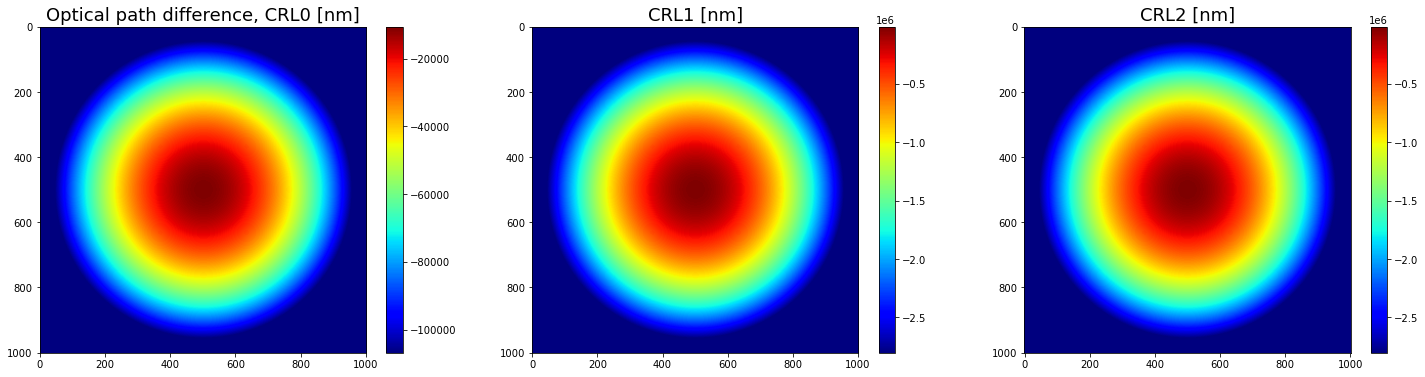

In [8]:
''' Lens demo '''
opd0=np.array(CRL0.arTr)[1::2].reshape(CRL0.mesh.ny,CRL0.mesh.nx,CRL0.mesh.ne)
opd1=np.array(CRL1.arTr)[1::2].reshape(CRL1.mesh.ny,CRL1.mesh.nx,CRL1.mesh.ne)
opd2=np.array(CRL2.arTr)[1::2].reshape(CRL2.mesh.ny,CRL2.mesh.nx,CRL2.mesh.ne)
plt.figure(figsize=(25,6))

plt.subplot(1,3,1)
plt.imshow(opd0[:,:,0]*1e9,cmap='jet')
plt.colorbar()
plt.title('Optical path difference, CRL0 [nm]', fontsize=18)

plt.subplot(1,3,2)
plt.imshow(opd1[:,:,0]*1e9,cmap='jet')
plt.colorbar()
plt.title('CRL1 [nm]', fontsize=18)

plt.subplot(1,3,3)
plt.imshow(opd2[:,:,0]*1e9,cmap='jet')
plt.colorbar()
plt.title('CRL2 [nm]', fontsize=18)


In [9]:
''' Drifts '''
im0_to_CRL0  = SRWLOptD(z_CRL0-z_im0)
CRL0_to_C1   = SRWLOptD(z_C1-z_CRL0)
C1_to_C2     = SRWLOptD(z_C2-z_C1)
C2_to_CRL1   = SRWLOptD(z_CRL1-z_C2)
CRL1_to_Slit = SRWLOptD(z_Slit-z_CRL1)
Slit_to_CRL2 = SRWLOptD(z_CRL2-z_Slit)
CRL2_to_C3   = SRWLOptD(z_C3-z_CRL2)
C3_to_C4     = SRWLOptD(z_C4-z_C3)
C4_to_output = SRWLOptD(z_output-z_C4)

''' Propagation method '''
#                  [0][1] [2] [3][4] [5]  [6]  [7]  [8]  [9] [10] [11] [12] [13] [14] [15] [16] 
pp_im0_to_CRL0 =  [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
pp_CRL0 =         [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
pp_CRL0_to_C1 =   [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
pp_C1 =           [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
pp_C1_to_C2 =     [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
pp_C2 =           [0, 0, 1.0, 0, 0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0] #
pp_C2_to_CRL1 =   [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
pp_CRL1 =         [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
pp_CRL1_to_Slit = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
pp_Slit =         [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
pp_Slit_to_CRL2 = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
pp_CRL2 =         [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
pp_CRL2_to_C3 =   [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
pp_C3 =           [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
pp_C3_to_C4 =     [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
pp_C4 =           [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
pp_C4_to_output = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]

#[ 0]: Auto-Resize (1) or not (0) Before propagation
#[ 1]: Auto-Resize (1) or not (0) After propagation
#[ 2]: Relative Precision for propagation with Auto-Resizing (1. is nominal)
#[ 3]: Allow (1) or not (0) for semi-analytical treatment of the quadratic (leading) phase terms at the propagation
#[ 4]: Do any Resizing on Fourier side, using FFT, (1) or not (0)
#[ 5]: Horizontal Range modification factor at Resizing (1. means no modification)
#[ 6]: Horizontal Resolution modification factor at Resizing
#[ 7]: Vertical Range modification factor at Resizing
#[ 8]: Vertical Resolution modification factor at Resizing
#[ 9]: Type of wavefront Shift before Resizing (not yet implemented)
#[10]: New Horizontal wavefront Center position after Shift (not yet implemented)
#[11]: New Vertical wavefront Center position after Shift (not yet implemented)
#[12]: Optional: Orientation of the Output Optical Axis vector in the Incident Beam Frame: Horizontal Coordinate
#[13]: Optional: Orientation of the Output Optical Axis vector in the Incident Beam Frame: Vertical Coordinate
#[14]: Optional: Orientation of the Output Optical Axis vector in the Incident Beam Frame: Longitudinal Coordinate
#[15]: Optional: Orientation of the Horizontal Base vector of the Output Frame in the Incident Beam Frame: Horizontal Coordinate
#[16]: Optional: Orientation of the Horizontal Base vector of the Output Frame in the Incident Beam Frame: Vertical Coordinate


In [10]:
''' Beamline '''
optBL0 = SRWLOptC([im0_to_CRL0, CRL0,
                CRL0_to_C1, C1, C1_to_C2, C2,
                C2_to_CRL1, CRL1, CRL1_to_Slit, Slit,
                Slit_to_CRL2, CRL2, CRL2_to_C3, C3,
                C3_to_C4, C4, C4_to_output],
               
               [pp_im0_to_CRL0, pp_CRL0,
                pp_CRL0_to_C1, pp_C1, pp_C1_to_C2, pp_C2,
                pp_C2_to_CRL1, pp_CRL1, pp_CRL1_to_Slit, pp_Slit,
                pp_Slit_to_CRL2, pp_CRL2, pp_CRL2_to_C3, pp_C3,
                pp_C3_to_C4, pp_C4, pp_C4_to_output])

bl0 = Beamline(optBL0)

In [11]:
''' Propagation '''
tstart = time.time()
name_out = dir_out+'mwf_out.h5'
mwf = propagate_wavefront(name_in, bl0, name_out)
print('propagation lasted: {}s'.format(round(time.time() - tstart,2)))

Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
	L = 50.0
	treat = 0
	
Optical Element: Transmission (generic)
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
	Fx = 0.005194164712014555
	Fy = 0.005194164712014555
	arTr = array of size 2004002
	extTr = 1
	input_parms = {'type': 'crl', 'focalPlane': 3, 'refractiveIndex': [0.211671308], 'attenuationLength': [1e+30], 'shape': 1, 'horizontalApertureSize': 0.002, 'verticalApertureSize': 0.002, 'radius': 0.0021989112771191284, 'numberOfLenses': 1, 'wallThickness': 5e-05, 'horizontalCenterCoordinate': 0.0, 'verticalCenterCoordinate': 0.0, 'voidCenterCoordinates': None, 'initialPhotonEnergy': -4e-12, 'finalPhotonPnergy': -4e-12, 'horizontalPoints': 1001, 'verticalPoints': 1001}
	mesh = Radiation Mesh (Sampling)
		arSurf = None
		eFin = -4e-12
		eStart = -4e-12
		hvx = 1
		hvy = 0
		hvz = 0
		ne = 1
		nvx = 0
		nvy = 0
		nvz = 1
		nx = 1001
		ny = 1001
		xFin = 0.0011
	

R-space


ValueError: Axis limits cannot be NaN or Inf

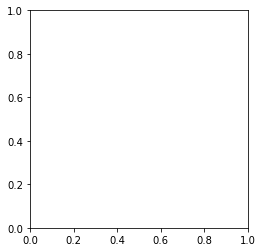

In [12]:
plot_spatial_from_wf(mwf)
#plt.xlim([-2500,2500])
